In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly

import zipfile
import os

import datetime

pd.options.mode.chained_assignment = None

In [2]:
# Let's define a function to get combined dataset from a given zip folder containing all 5-day data for a given week.
def get_week_worth_records(zip_file):
    file = zipfile.ZipFile(zip_file)
    
    df = pd.DataFrame()
    
    # read through all the files in the zip folder
    for txt_file in file.filelist:
        try:
            temp = file.read(txt_file.filename)
            #print(txt_file.filename)
            eod_data = temp.decode('utf-8').split('\r\n')
            splitted_eod_data = [val.split(',') for val in eod_data]

            temp_df = pd.DataFrame(splitted_eod_data, columns=['Code', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume'])


            df = pd.concat([df, temp_df], axis = 0)
        except ValueError:
            pass
        
    return df

In [3]:
# Let's create the combined price dataframe from the extracted txt files
combined_asx_df = pd.DataFrame()

for root, dirs, files in os.walk('data/', topdown=False):
    for name in files:
        file_name = os.path.join(root, name)
        
        combined_asx_df = pd.concat([combined_asx_df, get_week_worth_records(file_name)])
        
# We need to clean up this dataframe. First we remove the null values
combined_asx_df.dropna(inplace = True)

# Then, we convert the data type to datetime format
if ~(combined_asx_df['Date'].dtype == 'datetime64[ns]'):
        combined_asx_df['Date'] = [datetime.datetime.strptime(date, '%Y%m%d') for date in combined_asx_df['Date']]
        
# We then sort this data with the date
combined_asx_df.sort_values(by = 'Date', inplace = True)

# Then, change the price and volume data to floating point numbers
for column in combined_asx_df.columns[2:]:
        combined_asx_df[column] = combined_asx_df[column].astype(float)
    
print('Cleaned-up price dataframe is of size:', combined_asx_df.shape)

Cleaned-up price dataframe is of size: (210220, 7)


In [4]:
def get_company_price_data(df, code):
    """
    This function will return price dataframe for a given company (code).
    """
    filtered_df = df.loc[df['Code'] == code, :]
    return filtered_df

In [5]:
def plot_company_price_data(df, code, return_df = False):
    filtered_df = df.loc[df['Code'] == code, :]
    plt.figure(figsize = [12, 5])
    sns.lineplot(x = 'Date', y = 'Close', data = filtered_df)
    plt.grid(which = 'both')
    plt.show()
    
    if return_df:
        return filtered_df    

In [17]:
def get_trigger_table(company_df, visualize_macd = False, visualize_price = False):
    # Calculate the MACD and signal line indicators
    
    # Let's first calculate the short-term and long-term EMA 
    short_ema = company_df['Close'].ewm(span = 8, adjust = False).mean()
    long_ema = company_df['Close'].ewm(span = 17, adjust = False).mean()
    
    # Now, we will calculate the MACD line
    macd = short_ema - long_ema

    # Then the signal line
    signal = macd.ewm(span = 9).mean()

    company_df['MACD'] = macd
    company_df['Signal'] = signal
    
    company_df['Trigger'] = company_df['MACD'] - company_df['Signal']
    
    company_df.loc[company_df['Trigger']>=0, 'Trigger'] = 1
    company_df.loc[company_df['Trigger']<0, 'Trigger'] = -1
    
    
    # delay is the buying/selling delay from the trigger point (number of days passed the trigger)
    delay = 0
    zero_crossings = np.where(np.diff(np.sign(company_df['Trigger'])))[0] + delay
    
    a = company_df.iloc[zero_crossings, :]

    if visualize_price:
        plt.figure(figsize = [12, 5])
        plt.plot(company_df['Date'], company_df['Close'], color = 'k', alpha = 0.5)
        plt.grid(which = 'both')
        plt.scatter(a['Date'], a['Close'], c = a['Trigger'])
        plt.show()

    if visualize_macd:
        # Let's visualize this MACD data
        plt.figure(figsize = [12, 5])
        plt.plot(company_df['Date'], macd, color = 'red', label = 'MACD')
        plt.plot(company_df['Date'], signal, color = 'blue', label = 'Signal Line')
        plt.legend()
        plt.grid(which = 'both')
        plt.show()
    
    return a, zero_crossings

In [7]:
company = 'COL'
desired_df = get_company_price_data(combined_asx_df, company)

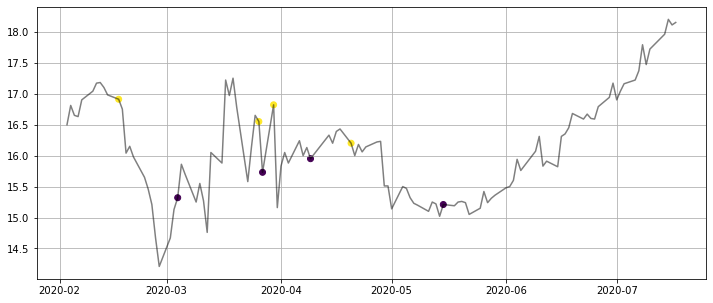

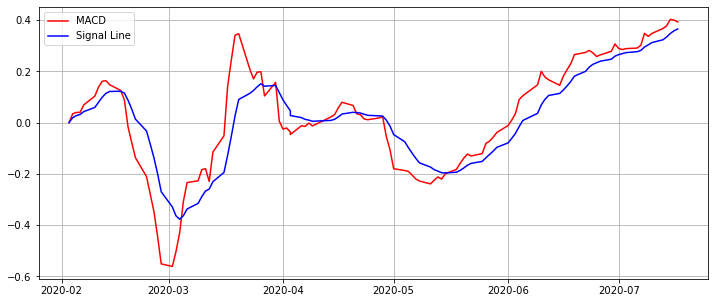

(    Code       Date   Open    High    Low  Close      Volume      MACD  \
 359  COL 2020-02-17  16.94  17.000  16.83  16.91   1612968.0  0.125605   
 347  COL 2020-03-04  15.06  15.340  15.00  15.32  10636106.0 -0.429138   
 338  COL 2020-03-26  16.94  16.940  16.30  16.55   6721667.0  0.198650   
 356  COL 2020-03-27  16.60  16.740  15.61  15.73   7478347.0  0.104019   
 353  COL 2020-03-30  15.63  16.865  15.51  16.82   4582873.0  0.157138   
 352  COL 2020-04-09  16.20  16.290  15.71  15.95   6744161.0 -0.012854   
 346  COL 2020-04-20  16.43  16.570  16.20  16.20   4161731.0  0.066727   
 347  COL 2020-05-15  15.10  15.210  14.95  15.21   2779601.0 -0.199363   
 
        Signal  Trigger  
 359  0.122428      1.0  
 347 -0.376848     -1.0  
 338  0.151423      1.0  
 356  0.141941     -1.0  
 353  0.144981      1.0  
 352  0.005263     -1.0  
 346  0.040204      1.0  
 347 -0.196181     -1.0  ,
 array([10, 22, 38, 39, 40, 49, 54, 73], dtype=int64))

In [18]:
get_trigger_table(desired_df, visualize_macd=True, visualize_price=True)

In [9]:
def get_profit(df, company, capital = 1000):    
    desired_df = get_company_price_data(df, company)

    trigger_df = get_trigger_table(desired_df, visualize_macd=False, visualize_price=False)

    trigger_df = trigger_df.iloc[1:, :]

    # Let's calculate the profit
    trigger_df['Profit_per_Unit'] = trigger_df['Close'].diff()
    trigger_df['Units_Bought'] = capital/(trigger_df['Close'] - trigger_df['Profit_per_Unit'])

    # Remember, selling points at trigger = -1 and buying points at trigger = +1.
    req_cols = ['Code', 'Date', 'Close', 'Profit_per_Unit', 'Units_Bought']
    trades_df = trigger_df.loc[trigger_df['Trigger'] == 1, req_cols]
    trades_df['Total_Profit'] = trades_df['Profit_per_Unit'] * trades_df['Units_Bought']

    #print('Total Profit with Trades from', company, ': $', round(trades_df['Total_Profit'].sum(), 2))
    return round(trades_df['Total_Profit'].sum(), 2)

In [14]:
profit = []

company_list = combined_asx_df.Code.unique()
for code in company_list:
    profit.append(get_profit(combined_asx_df, code))

profit_df = pd.DataFrame({'Code': company_list, 'Profit': profit})

profit_df.head()

,Code,Profit
0,360,266.00
1,PAB,387.18
2,PAA,1957.83
3,P2P,0.00
4,OZR,335.91


In [16]:
profit_df.loc[profit_df['Profit'] <0, :]

,Code,Profit
46,PAN,-200.22
165,PIN,-206.63
177,PSC,-173.45
252,LIO,-50.00
291,LOM,-360.52
...,...,...
2449,DBBF,-6.17
2464,FUEL,-11.37
2468,FOOD,-6.15
2481,ESTX,-10.39


In [12]:
profit_df.shape

(2531, 2)

In [13]:
profit = []

company_list = ['WES', 'COL', 'NAB', 'CBA', 'CSL', '5GN', 'CCP', 'SIQ', 'WEB', 'ALU', 'TLS']
for code in company_list:
    profit.append(get_profit(combined_asx_df, code))

profit_df1 = pd.DataFrame({'Code': company_list, 'Profit': profit})

profit_df1

,Code,Profit
0,WES,333.29
1,COL,165.26
2,NAB,223.90
3,CBA,245.60
4,CSL,185.98
5,5GN,928.04
6,CCP,635.98
7,SIQ,456.33
8,WEB,852.64
9,ALU,443.81


In [14]:
profit_df['Bin'] = pd.qcut(x = profit_df['Profit'], q = 5)

In [15]:
profit_df.groupby(by = 'Bin').mean()

,Profit
Bin,
"(-360.52099999999996, 0.0]",-11.155328
"(0.0, 236.5]",110.396258
"(236.5, 547.16]",385.935237
"(547.16, 1060.31]",778.055395
"(1060.31, 91333.33]",2617.736107


In [16]:
profit_df.groupby(by = 'Bin').count()

,Code,Profit
Bin,,
"(-360.52099999999996, 0.0]",548,548
"(0.0, 236.5]",465,465
"(236.5, 547.16]",506,506
"(547.16, 1060.31]",506,506
"(1060.31, 91333.33]",506,506


In [17]:
profit_df.sort_values(by = 'Profit', ascending = False)

,Code,Profit,Bin
1298,GTE,91333.33,"(1060.31, 91333.33]"
1005,AHZ,59223.06,"(1060.31, 91333.33]"
1848,MAR,41000.00,"(1060.31, 91333.33]"
434,VOR,34505.51,"(1060.31, 91333.33]"
940,CTM,28929.73,"(1060.31, 91333.33]"
...,...,...,...
1658,CLT,-278.94,"(-360.52099999999996, 0.0]"
1648,AJJ,-294.12,"(-360.52099999999996, 0.0]"
1907,EER,-333.33,"(-360.52099999999996, 0.0]"
1844,MCM,-334.02,"(-360.52099999999996, 0.0]"


In [37]:
temp_df = get_company_price_data(combined_asx_df, 'QAN')
get_trigger_table(temp_df)

,Code,Date,Open,High,Low,Close,Volume,MACD,Signal,Trigger
1126,QAN,2020-02-07,6.73,6.74,6.465,6.48,7317524.0,0.046278,0.034701,1.0
1158,QAN,2020-02-19,6.23,6.34,6.220,6.30,8075694.0,-0.028201,0.002677,-1.0
1123,QAN,2020-02-21,6.61,6.64,6.420,6.51,13532030.0,0.015952,0.006401,1.0
1086,QAN,2020-03-24,2.58,2.63,2.460,2.59,18862803.0,-0.748049,-0.721165,-1.0
1111,QAN,2020-05-05,3.70,3.76,3.580,3.62,14373024.0,0.057452,0.046404,1.0
1147,QAN,2020-05-20,3.44,3.56,3.400,3.53,10284409.0,-0.011269,-0.007261,-1.0
1772,QAN,2020-06-12,4.31,4.54,4.170,4.49,29067507.0,0.256070,0.227992,1.0
1765,QAN,2020-07-15,3.55,3.65,3.500,3.64,10577937.0,-0.142968,-0.135896,-1.0


In [59]:
get_profit(combined_asx_df, 'QAN')

KeyError: 'Code'

In [25]:
combined_asx_df.loc[(combined_asx_df['Date'] == '2020-05-20') & (combined_asx_df['Code'] == 'CCP'), :]         

,Code,Date,Open,High,Low,Close,Volume
296,CCP,2020-05-20,14.47,15.45,14.35,15.43,653610.0


## Historical 2017/01 - 2019/12 Data

In [56]:
df = pd.DataFrame()

for root, dirs, files in os.walk('historical_data/', topdown=False):
    for name in files:
        file_name = os.path.join(root, name)
    
        try:
            temp = open(file_name, 'r')
            eod_data = temp.read().split('\n')
            splitted_eod_data = [val.split(',') for val in eod_data]

            temp_df = pd.DataFrame(splitted_eod_data, columns=['Code', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume'])


            df = pd.concat([df, temp_df], axis = 0)
        except ValueError:
            pass

df.shape
    

(1203700, 7)

In [57]:
       
# We need to clean up this dataframe. First we remove the null values
df.dropna(inplace = True)

# Then, we convert the data type to datetime format
if ~(df['Date'].dtype == 'datetime64[ns]'):
        df['Date'] = [datetime.datetime.strptime(date, '%Y%m%d') for date in df['Date']]
        
# We then sort this data with the date
df.sort_values(by = 'Date', inplace = True)

# Then, change the price and volume data to floating point numbers
for column in df.columns[2:]:
        df[column] = df[column].astype(float)
    
print('Cleaned-up price dataframe is of size:', df.shape)

Cleaned-up price dataframe is of size: (1202942, 7)


In [62]:
df.head()

,Code,Date,Open,High,Low,Close,Volume
0,1AD,2017-01-03,0.165,0.185,0.165,0.185,77000.0
1002,PEP,2017-01-03,2.550,2.550,2.500,2.500,6192.0
1001,PEN,2017-01-03,0.560,0.560,0.545,0.545,44032.0
1000,PEA,2017-01-03,0.600,0.600,0.580,0.580,90902.0
999,PDZ,2017-01-03,0.370,0.390,0.365,0.390,19426.0


In [119]:
profit = []

#company_list = ['WES', 'COL', 'NAB', 'CBA', 'CSL', '5GN', 'CCP', 'SIQ', 'WEB', 'ALU', 'TLS']
company_list = df.Code.unique()
for code in company_list:
    profit.append(get_profit(df, code))

profit_df1 = pd.DataFrame({'Code': company_list, 'Profit': profit})

profit_df1

,Code,Profit
0,1AD,880.95
1,PEP,394.43
2,PEN,-558.94
3,PEA,460.70
4,PDZ,519.02
...,...,...
2594,LME,0.00
2595,HWH,0.00
2596,ICE,0.00
2597,CPT,0.00


In [123]:
profit_df1[profit_df1['Profit']>0].shape

(2044, 2)

In [99]:
temp_df = get_company_price_data(df, 'NAB')
t_df = get_trigger_table(temp_df)
t_df

,Code,Date,Open,High,Low,Close,Volume,MACD,Signal,Trigger
917,NAB,2017-01-12,31.40,31.660,31.34,31.52,3946386.0,0.137350,0.124028,1.0
943,NAB,2017-01-31,30.43,30.490,30.08,30.33,4546401.0,-0.200348,-0.191499,-1.0
934,NAB,2017-03-03,32.26,32.300,32.03,32.13,3061851.0,0.303023,0.296291,1.0
958,NAB,2017-03-07,32.09,32.480,32.04,32.42,3261768.0,0.291662,0.293723,-1.0
961,NAB,2017-03-14,33.07,33.280,32.84,32.91,3939236.0,0.390216,0.352799,1.0
...,...,...,...,...,...,...,...,...,...,...
912,NAB,2019-10-15,28.40,28.530,28.35,28.45,2210870.0,-0.184229,-0.122835,-1.0
934,NAB,2019-10-30,28.94,29.110,28.85,28.93,4865418.0,0.107133,0.067213,1.0
906,NAB,2019-11-08,28.50,28.665,28.17,28.47,8382721.0,-0.149295,-0.103215,-1.0
908,NAB,2019-11-13,29.10,29.180,28.78,28.79,9484283.0,0.025973,-0.056292,1.0


In [91]:
capital = 1000
t_df = t_df.iloc[1:, :]

# Let's calculate the profit
t_df['Profit_per_Unit'] = t_df['Close'].diff()
t_df['Units_Bought'] = capital/(t_df['Close'] - t_df['Profit_per_Unit'])

# Remember, selling points at trigger = -1 and buying points at trigger = +1.
req_cols = ['Code', 'Date', 'Close', 'Profit_per_Unit', 'Units_Bought']
trades_df = t_df.loc[t_df['Trigger'] == 1, req_cols]
trades_df['Total_Profit'] = trades_df['Profit_per_Unit'] * trades_df['Units_Bought']

print('Total Profit with Trades from', company, ': $', round(trades_df['Total_Profit'].sum(), 2))


Total Profit with Trades from COL : $ 681.98


In [86]:
trades_df.shape

(40, 6)

In [87]:
trades_df.head()

,Code,Date,Close,Profit_per_Unit,Units_Bought,Total_Profit
299,CBA,2017-02-23,83.48,1.97,12.268433,24.168814
285,CBA,2017-03-21,84.42,0.89,11.971747,10.654855
289,CBA,2017-04-06,84.79,1.39,11.990408,16.666667
290,CBA,2017-04-13,86.25,0.15,11.614402,1.742160
302,CBA,2017-05-02,86.83,0.60,11.596892,6.958135


In [92]:
trades_df[trades_df['Total_Profit']<0]

,Code,Date,Close,Profit_per_Unit,Units_Bought,Total_Profit
984,NAB,2017-06-23,29.31,-0.42,33.636058,-14.127144
1039,NAB,2018-04-18,28.44,-0.43,34.638033,-14.894354
1062,NAB,2018-06-13,26.14,-0.66,37.313433,-24.626866
970,NAB,2018-09-04,28.22,-0.08,35.335689,-2.826855
962,NAB,2018-09-26,27.45,-0.37,35.945363,-13.299784
944,NAB,2018-11-12,24.88,-0.08,40.064103,-3.205128
928,NAB,2019-02-11,24.35,-0.27,40.617384,-10.966694
914,NAB,2019-04-04,25.17,-0.10,39.572616,-3.957262


In [106]:
trades_df[trades_df['Total_Profit']>0]

,Code,Date,Close,Profit_per_Unit,Units_Bought,Total_Profit
934,NAB,2017-03-03,32.13,1.80,32.970656,59.347181
961,NAB,2017-03-14,32.91,0.49,30.845157,15.114127
945,NAB,2017-04-05,32.91,0.07,30.450670,2.131547
966,NAB,2017-05-03,33.09,0.02,30.238887,0.604778
911,NAB,2017-07-17,29.94,0.79,34.305317,27.101201
949,NAB,2017-07-27,30.51,1.11,34.013605,37.755102
961,NAB,2017-08-22,30.83,0.65,33.134526,21.537442
927,NAB,2017-10-03,31.51,0.99,32.765400,32.437746
1014,NAB,2017-10-27,32.62,0.99,31.615555,31.299399
1016,NAB,2018-01-12,29.53,0.15,34.036760,5.105514


In [ ]:
get_trigger_table()

## API for Pricing

https://www.alphavantage.co/documentation/

6FK73MI9CORO78E1

In [107]:
df.shape

(1202942, 7)

## What if we buy/sell after one day from trigger event

In [108]:
company_df = get_company_price_data(df, 'CBA')
company_df.shape

(758, 7)

In [115]:
# Let's first calculate the short-term and long-term EMA 
short_ema = company_df['Close'].ewm(span = 8, adjust = False).mean()
long_ema = company_df['Close'].ewm(span = 17, adjust = False).mean()
    
# Now, we will calculate the MACD line
macd = short_ema - long_ema

# Then the signal line
signal = macd.ewm(span = 9).mean()

company_df['MACD'] = macd
company_df['Signal'] = signal

company_df['Trigger'] = company_df['MACD'] - company_df['Signal']

company_df.loc[company_df['Trigger']>=0, 'Trigger'] = 1
company_df.loc[company_df['Trigger']<0, 'Trigger'] = -1
zero_crossings = np.where(np.diff(np.sign(company_df['Trigger'])))[0]

a = company_df.iloc[zero_crossings, :]

zero_crossings + 1

array([  9,  25,  37,  47,  55,  59,  67,  70,  72,  77,  82,  98, 100,
       103, 107, 108, 128, 137, 144, 174, 209, 216, 225, 240, 253, 255,
       262, 273, 276, 288, 305, 316, 326, 328, 331, 333, 339, 353, 356,
       357, 363, 366, 385, 404, 409, 427, 438, 455, 459, 461, 475, 479,
       487, 502, 519, 529, 534, 540, 551, 567, 575, 576, 590, 599, 609,
       611, 617, 620, 625, 645, 651, 667, 690, 704, 716, 723, 732, 734,
       739, 747, 756], dtype=int64)

In [116]:
company_df.head(10)

,Code,Date,Open,High,Low,Close,Volume,MACD,Signal,Trigger
275,CBA,2017-01-03,82.40,83.16,82.310,82.97,1967692.0,0.000000,0.000000,1.0
276,CBA,2017-01-04,83.50,83.76,83.200,83.61,2086820.0,0.071111,0.039506,1.0
278,CBA,2017-01-05,83.99,84.12,83.590,83.85,2049692.0,0.145185,0.082817,1.0
292,CBA,2017-01-06,83.98,84.18,83.620,84.13,2648142.0,0.223923,0.130617,1.0
288,CBA,2017-01-09,84.28,85.65,84.175,85.26,2742640.0,0.398386,0.210272,1.0
284,CBA,2017-01-10,84.99,85.16,84.430,84.82,2345467.0,0.460277,0.278037,1.0
294,CBA,2017-01-11,84.70,85.21,84.570,85.00,2342921.0,0.511700,0.337171,1.0
282,CBA,2017-01-12,85.00,85.59,84.700,85.03,2215463.0,0.537951,0.385422,1.0
293,CBA,2017-01-13,85.04,85.04,83.340,83.86,2522301.0,0.412817,0.391751,1.0
301,CBA,2017-01-16,84.29,84.41,83.750,84.09,1338272.0,0.341668,0.380529,-1.0
